In [ ]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing the required libraries
import time
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})

# Libraries for methods considered in the study
import xgboost as xgb

# Libraries for cross validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Libraries for hyperparameter tuning
# bayesian optimization baased hyperOpt library
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

# For analyzing feature importance
import shap

Check library versions

In [ ]:
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"hyperOpt version: {hyperopt.__version__}")
print(f"SHAP version: {shap.__version__}")

NumPy version: 1.26.4
Pandas version: 2.1.4
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
Scikit-learn version: 1.3.2
hyperOpt version: 0.2.7
SHAP version: 0.46.0


In [ ]:
# folder containing the datasets
data_path = '/Path/to/data/'
# folder for saving the figures
fig_path = '/Path/to/save/figures/'

In [ ]:
random_seed = 216

# correlation cutoff for features
# i.e. only one of the features among features with corr > corr_cutoff will be kept
corr_cutoff = 0.8

## Load Data


In [ ]:
X_train = pd.read_csv(data_path + 'X_train_train_049depth.csv').drop(columns=['Unnamed: 0'])
y_train = pd.read_csv(data_path + 'y_train_train_049depth.csv').drop(columns=['Unnamed: 0']).values

In [ ]:
X_train.shape, y_train.shape

((237262, 19), (237262, 1))

In [ ]:
X_val = pd.read_csv(data_path + 'X_train_test_049depth.csv').drop(columns=['Unnamed: 0'])
y_val = pd.read_csv(data_path + 'y_train_test_049depth.csv').drop(columns=['Unnamed: 0']).values

In [ ]:
X_val.shape, y_val.shape

((79088, 19), (79088, 1))

In [ ]:
X_test = pd.read_csv(data_path + 'X_test_049depth.csv').drop(columns=['Unnamed: 0'])
y_test = pd.read_csv(data_path + 'y_test_049depth.csv').drop(columns=['Unnamed: 0']).values

In [ ]:
X_test.shape, y_test.shape

((105451, 19), (105451, 1))

In [ ]:
all_features = X_train.columns.tolist()
all_features

['year',
 'month',
 'latitude',
 'longitude',
 'fgco2',
 'omega_ar',
 'omega_ca',
 'ph',
 'spco2',
 'talk',
 'tco2',
 'fe',
 'no3',
 'o2',
 'po4',
 'si',
 'sos',
 'dos',
 'analysed_sst']

## Remove correlated features

Correlation between features

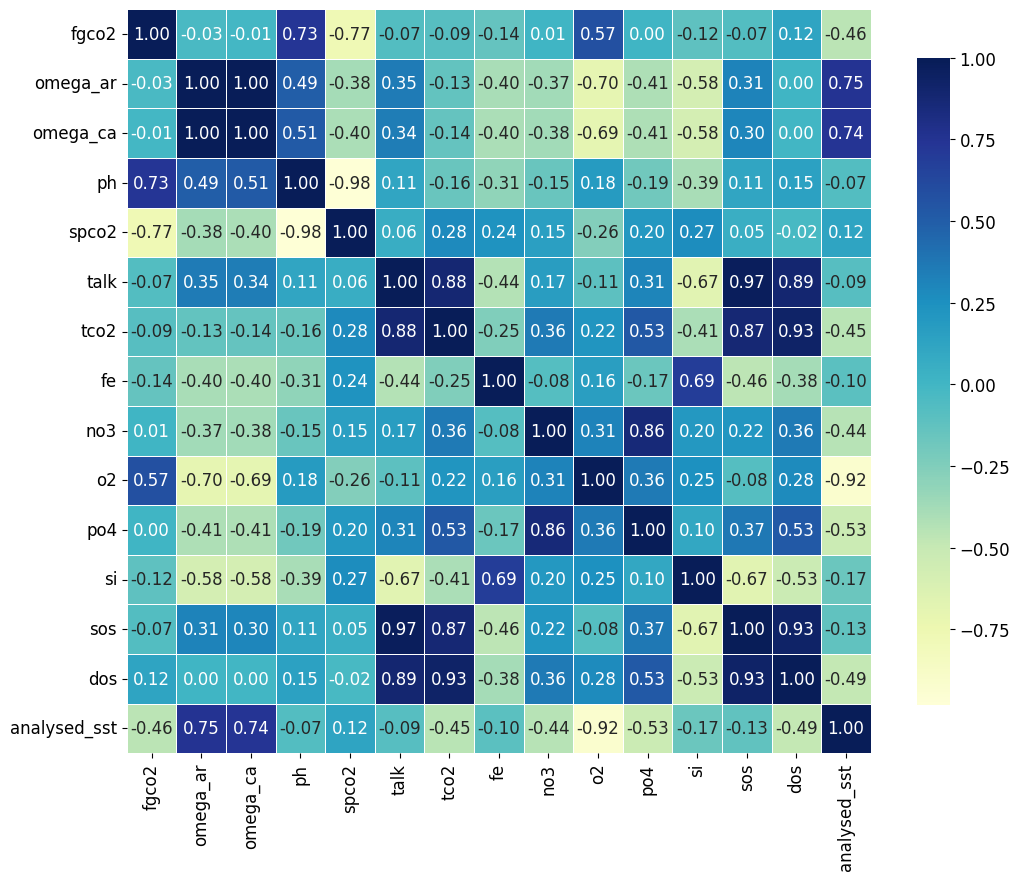

In [ ]:
correlations = X_train.drop(columns=["year","month","latitude","longitude"]).corr()
plt.subplots(figsize = (12, 12))
sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f', cmap = "YlGnBu",
            square = True, linewidths = 0.5, annot = True, cbar_kws = {"shrink": .70})
plt.savefig(fig_path + 'correlation_heatmap.png')
plt.show()

Features with correlation > 0.8
1. [ph, spco2]
2. [omega_ar, omega_ca]
3. [sos, dos, talk, tco2]
4. [no3, po4]
4. [o2, analysed_sst]

In [ ]:
# Features to be removed based on the correlation cutoff
if corr_cutoff == 0.7:
  features_to_remove = ["fgco2","spco2","omega_ar","omega_ca","dos","talk","tco2","po4", "analysed_sst"]
elif corr_cutoff == 0.8:
  features_to_remove = ["spco2","omega_ar","dos","talk","tco2","po4", "analysed_sst"]

# features to keep
feature_names = [x for x in all_features if x not in features_to_remove]
print("Final feature list:")
feature_names

Final feature list:


['year',
 'month',
 'latitude',
 'longitude',
 'fgco2',
 'omega_ca',
 'ph',
 'fe',
 'no3',
 'o2',
 'si',
 'sos']

In [ ]:
# Keep only columns corresponding to final feature list from X_train and X_val
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [ ]:
# convert dataframe to arrays
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

X_train.shape, X_val.shape, X_test.shape

((237262, 12), (79088, 12), (105451, 12))

## Helper functions

In [ ]:
def rmse(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like.
        Ground truth (correct) target values.
    y_pred : array-like.
        Estimated target values.

    Output
    ------
    Root mean squared error
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like.
        Ground truth (correct) target values.
    y_pred : array-like.
        Estimated target values.

    Output
    ------
    Mean absolute percentage error
    """
    return mean_absolute_percentage_error(y_true, y_pred)

In [ ]:
##Code for using hyperopt for hysperparameter search to optimize RMSE is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Function to compute the optimal hyperparamter values using hyperOpt
def opt_hyperparameter(parameter_space,func_model,max_iterations):
    """
    Parameters
    ----------
    parameter_space : dict
        parameter space to be explored for optimizing F1 score where each key refers to a hyperparamter
        and that key's corresponding value defines the space to be explored for that hyperparamter
    func_model : value-returning function
        To be minimized by hyperopt.fmin(). In our case, since we want to minimize rmse, func_model returns
        as mean rmse from 5-fold cross validation
    max_iterations : Int
        maximum number of evaluations the fmin function will perform

    Output
    ------
    best: dict
        Optimal hyperparameter values obtained from fmin
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    trials = Trials()
    best = fmin(fn = func_model, space = parameter_space, algo=tpe.suggest, max_evals=max_iterations, trials=trials)

    return best, trials

##================================
##Function for plotting optimization history (RMSE vs iteration number)
##Taken from https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt
def optimization_history(trials):
    """
    Parameters
    ----------
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(trials) + 1), [x['result']['loss'] for x in trials],
            color='red', marker='.', linewidth=0)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('Optimization history', fontsize=14)
    plt.grid(True)

## Baseline model

Prediction = average value of chlorophyll in the train set

In [ ]:
baseline_model = np.mean(y_train)
print(f'Baseline model prediction: {baseline_model}')

Baseline model prediction: 1.2473373493659838


In [ ]:
print(f"RMSE for baseline model: {rmse(y_val, np.ones(len(y_val))*baseline_model):.2f}")
print(f"MAPE for baseline model: {mape(y_val, np.ones(len(y_val))*baseline_model):.2f}")

RMSE for baseline model: 1.03
MAPE for baseline model: 1.08


## XGBoost model

### Bayesian Hyperparameter tuning

**NOTE:** \\
**1) Run time for the following hyperparamter search is ~10 min when run on GPUs. Running on CPU would considerably longer.** \\
**2) Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**3) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean RMSE (average over 5-fold CV on the training set) from the search would still be ~0.33 for XGBoost.**

{'colsample_bytree': 0.5154247277260442, 'gamma': 0.12252480115714354, 'learning_rate': 0.23385842393827164, 'max_depth': 6, 'min_child_weight': 0.26945407590383996, 'n_estimators': 980, 'reg_alpha': 0.19637564875169877, 'reg_lambda': 0.9863321870223019, 'subsample': 0.6939431044562137}
{'colsample_bytree': 0.6679234113935243, 'gamma': 0.23266827941016627, 'learning_rate': 0.1439651540827149, 'max_depth': 3, 'min_child_weight': 6.267905990982645, 'n_estimators': 417, 'reg_alpha': 2.465132324844424, 'reg_lambda': 4.513583709236228, 'subsample': 0.7142088749389405}
{'colsample_bytree': 0.9859824163320672, 'gamma': 0.42845071335672913, 'learning_rate': 0.09558020343347028, 'max_depth': 3, 'min_child_weight': 7.177873884671957, 'n_estimators': 213, 'reg_alpha': 0.579200518046713, 'reg_lambda': 0.5717975247850815, 'subsample': 0.5111160240186532}
{'colsample_bytree': 0.6496978243165961, 'gamma': 0.43648550499324457, 'learning_rate': 0.29761377543919215, 'max_depth': 8, 'min_child_weight': 5

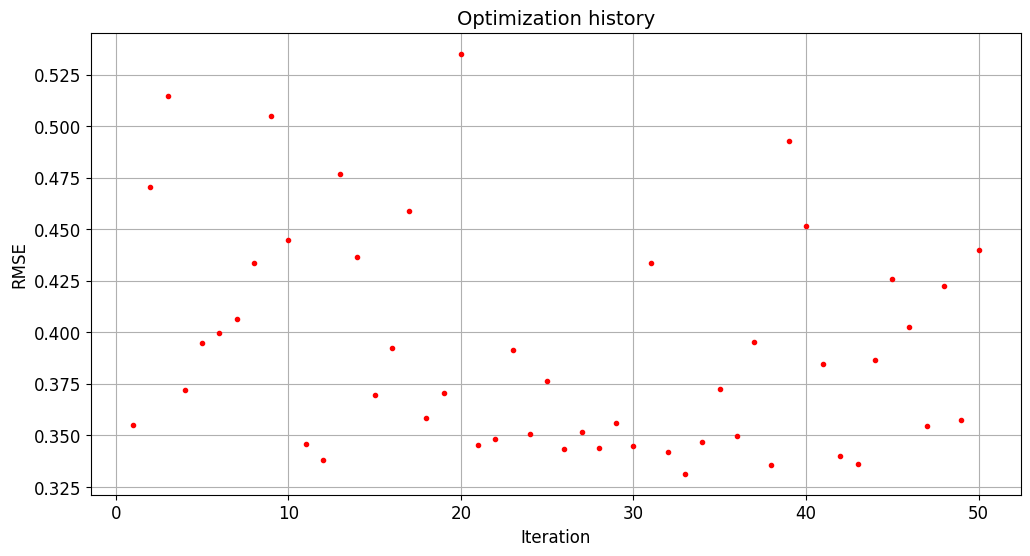

In [ ]:
##Code for using hyperopt for hysperparameter search to optimze RMSE taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
xgbr_param_space = {'max_depth': hp.choice('max_depth', range(3,9)),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.5),
                    'subsample': hp.uniform('subsample',0.5,1.0),
                    'n_estimators': hp.choice('n_estimators', range(100,1000)),
                    'reg_lambda': hp.uniform('reg_lambda',0,5), #L2 regularization
                    'reg_alpha': hp.uniform('reg_alpha',0,5), #L1 regularization
                    'min_child_weight': hp.uniform('min_child_weight',0,10),
                    'gamma': hp.uniform('gamma',0,0.5),
                    'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean rmse (averaged over k-fold CV)
##which is being optimized by hyprOpt.fmin().
def xgbr_func(params):
    global best
    print(params)

    ##Define XGBoost regressor
    ##NOTE: couldn't find RMSE equivalent among inbuilt obj functions in xgboost
    ##https://xgboost.readthedocs.io/en/latest/parameter.html
    reg = xgb.XGBRegressor(tree_method='hist',objective='reg:squarederror', device="cuda",
                           random_state=random_seed,**params)
    ##Compute the mean score for kfold cross validation
    score = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of rmse.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 50
##Find the optimal hyperparamter set. Also storing the optimization history
xgbr_param_space_indices, xgbr_trials = opt_hyperparameter(xgbr_param_space,xgbr_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by xgbc_param_space_indices
xgbr_best_hp = space_eval(xgbr_param_space,xgbr_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(xgbr_best_hp)
print('---------------Optimization History-------------------')
optimization_history(xgbr_trials)

The cell below has the optimal hyperparameters found for XGBoost regressor after running the search in previous cell. \\

**Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search. Also, this is for the case of corr_cutoff = 0.8** \\

Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the RMSE on the validation set should still be ~0.32.

In [ ]:
# For 0.8 cutoff
#xgbr_best_hp = {'colsample_bytree': 0.6416557684630159, 'gamma': 0.03586598978361506, 'learning_rate': 0.32352381782820916, 'max_depth': 8, 'min_child_weight': 2.2337154033026327, 'n_estimators': 933, 'reg_alpha': 0.6544680866445873, 'reg_lambda': 4.6244759386524805, 'subsample': 0.7415169009213295}

### Assess performance on Validation set

In [ ]:
# Get the best parameters
best_params = xgbr_best_hp

print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params, tree_method='hist',
                              objective='reg:squarederror', device="cuda",
                              random_state=random_seed)

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_best = best_model.predict(X_val)

# Evaluate the best model
print(f"RMSE: {rmse(y_val, y_pred_best):.2f}")
print(f"MAPE: {mape(y_val, y_pred_best):.2f}")

Best Parameters: {'colsample_bytree': 0.6416557684630159, 'gamma': 0.03586598978361506, 'learning_rate': 0.32352381782820916, 'max_depth': 8, 'min_child_weight': 2.2337154033026327, 'n_estimators': 933, 'reg_alpha': 0.6544680866445873, 'reg_lambda': 4.6244759386524805, 'subsample': 0.7415169009213295}
RMSE: 0.32
MAPE: 0.17


### SHAP on test set

In [ ]:
# Model hyperparameters from hyperparameter tuning
xgbr_params = {'colsample_bytree': 0.6416557684630159, 'gamma': 0.03586598978361506, 'learning_rate': 0.32352381782820916,
               'max_depth': 8, 'min_child_weight': 2.2337154033026327, 'n_estimators': 933, 'reg_alpha': 0.6544680866445873,
               'reg_lambda': 4.6244759386524805, 'subsample': 0.7415169009213295}

# Create model
model = xgb.XGBRegressor(**xgbr_params, tree_method='hist',
                         objective='reg:squarederror', device="cuda",
                         random_state=random_seed)

# Fit model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6416557684630159, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.03586598978361506,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.32352381782820916,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2.2337154033026327, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=933,
             n_jobs=None, num_parallel_tree=None, random_state=216, ...)

In [ ]:
#Performance on test set
y_pred = model.predict(X_test)
print(f"RMSE: {rmse(y_test, y_pred):.2f}")
print(f"MAPE: {mape(y_test, y_pred):.2f}")

RMSE: 0.32
MAPE: 0.17


Running the following SHAP cell on CPU would be too slow. Consider using GPU

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

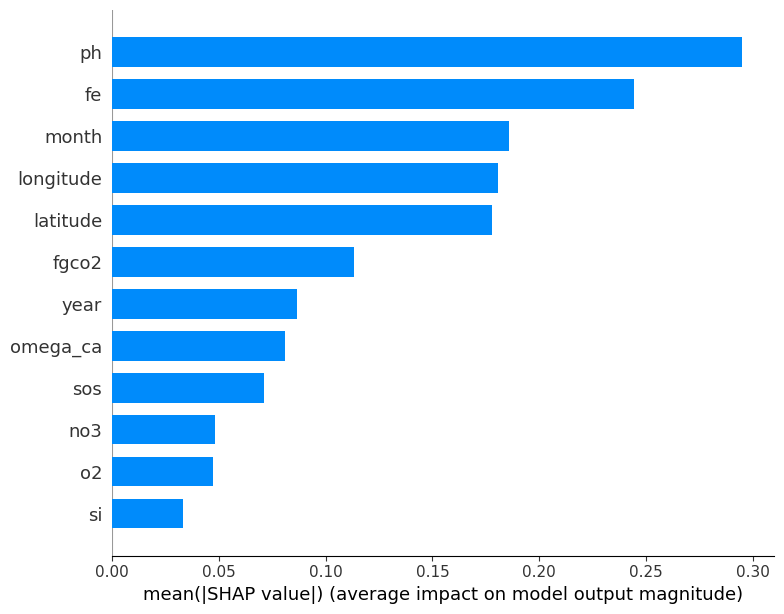

In [ ]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, feature_names, plot_type="bar", show=False)
plt.savefig(fig_path + 'shap_summary_bar.png')
plt.show()

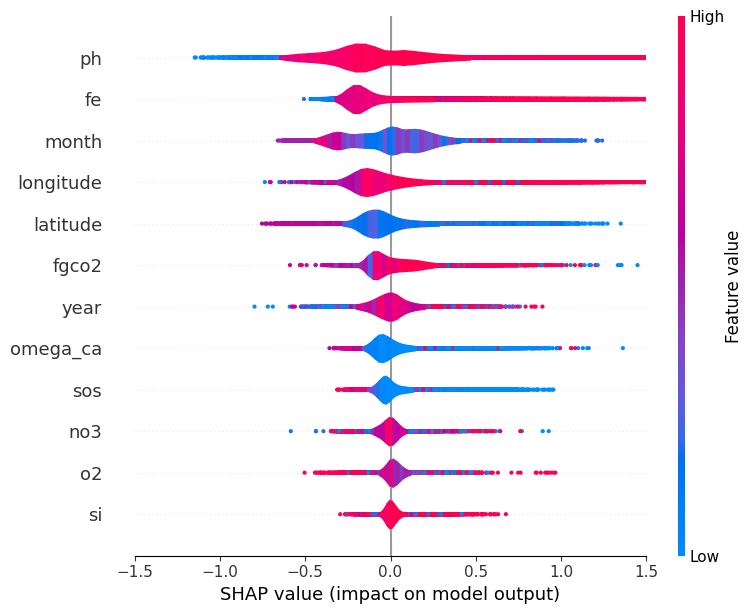

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names, plot_type = "violin", show = False)
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
plt.savefig(fig_path + 'shap_summary_violin.png')
plt.show()